# Training : Text-to-image
- Ref: https://huggingface.co/docs/diffusers/v0.34.0/en/training/text2image

In [1]:
#@title
import torch

if torch.backends.mps.is_available():
    t_device = torch.device("mps")
    s_device = "mps"
    print(f"Current memory allocated on MPS: {torch.mps.current_allocated_memory()} bytes")
    print(f"Driver memory allocated on MPS: {torch.mps.driver_allocated_memory()} bytes")
elif torch.cuda.is_available():
    t_device = torch.device("cuda")
    s_device = "cuda"
else:
    t_device = torch.device("cpu")
    s_device = "cpu"
print(s_device)

Current memory allocated on MPS: 0 bytes
Driver memory allocated on MPS: 393216 bytes
mps


### 1. Setup acclerate

In [2]:
! accelerate config default

Configuration already exists at /Users/hyunjae.k/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


### 2. Prepare a training script
- Ref: https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py

In [ ]:
%%writefile temp_train_text_to_image.py

#!/usr/bin/env python
# coding=utf-8
# Copyright 2025 The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import argparse
import logging
import math
import os
import random
import shutil
from contextlib import nullcontext
from pathlib import Path

import accelerate
import datasets
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.state import AcceleratorState
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from packaging import version
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from transformers.utils import ContextManagers

import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel, compute_dream_and_update_latents, compute_snr
from diffusers.utils import check_min_version, deprecate, is_wandb_available, make_image_grid
from diffusers.utils.hub_utils import load_or_create_model_card, populate_model_card
from diffusers.utils.import_utils import is_xformers_available
from diffusers.utils.torch_utils import is_compiled_module


if is_wandb_available():
    import wandb


# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
# check_min_version("0.35.0.dev0")

logger = get_logger(__name__, log_level="INFO")

DATASET_NAME_MAPPING = {
    "lambdalabs/naruto-blip-captions": ("image", "text"),
}


def save_model_card(
    args,
    repo_id: str,
    images: list = None,
    repo_folder: str = None,
):
    img_str = ""
    if len(images) > 0:
        image_grid = make_image_grid(images, 1, len(args.validation_prompts))
        image_grid.save(os.path.join(repo_folder, "val_imgs_grid.png"))
        img_str += "![val_imgs_grid](./val_imgs_grid.png)\n"

    model_description = f"""
# Text-to-image finetuning - {repo_id}

This pipeline was finetuned from **{args.pretrained_model_name_or_path}** on the **{args.dataset_name}** dataset. Below are some example images generated with the finetuned pipeline using the following prompts: {args.validation_prompts}: \n
{img_str}

## Pipeline usage

You can use the pipeline like so:

```python
from diffusers import DiffusionPipeline
import torch

pipeline = DiffusionPipeline.from_pretrained("{repo_id}", torch_dtype=torch.float16)
prompt = "{args.validation_prompts[0]}"
image = pipeline(prompt).images[0]
image.save("my_image.png")
```

## Training info

These are the key hyperparameters used during training:

* Epochs: {args.num_train_epochs}
* Learning rate: {args.learning_rate}
* Batch size: {args.train_batch_size}
* Gradient accumulation steps: {args.gradient_accumulation_steps}
* Image resolution: {args.resolution}
* Mixed-precision: {args.mixed_precision}

"""
    wandb_info = ""
    if is_wandb_available():
        wandb_run_url = None
        if wandb.run is not None:
            wandb_run_url = wandb.run.url

    if wandb_run_url is not None:
        wandb_info = f"""
More information on all the CLI arguments and the environment are available on your [`wandb` run page]({wandb_run_url}).
"""

    model_description += wandb_info

    model_card = load_or_create_model_card(
        repo_id_or_path=repo_id,
        from_training=True,
        license="creativeml-openrail-m",
        base_model=args.pretrained_model_name_or_path,
        model_description=model_description,
        inference=True,
    )

    tags = ["stable-diffusion", "stable-diffusion-diffusers", "text-to-image", "diffusers", "diffusers-training"]
    model_card = populate_model_card(model_card, tags=tags)

    model_card.save(os.path.join(repo_folder, "README.md"))


def log_validation(vae, text_encoder, tokenizer, unet, args, accelerator, weight_dtype, epoch):
    logger.info("Running validation... ")

    pipeline = StableDiffusionPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        vae=accelerator.unwrap_model(vae),
        text_encoder=accelerator.unwrap_model(text_encoder),
        tokenizer=tokenizer,
        unet=accelerator.unwrap_model(unet),
        safety_checker=None,
        revision=args.revision,
        variant=args.variant,
        torch_dtype=weight_dtype,
    )
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)

    if args.enable_xformers_memory_efficient_attention:
        pipeline.enable_xformers_memory_efficient_attention()

    if args.seed is None:
        generator = None
    else:
        generator = torch.Generator(device=accelerator.device).manual_seed(args.seed)

    images = []
    for i in range(len(args.validation_prompts)):
        if torch.backends.mps.is_available():
            autocast_ctx = nullcontext()
        else:
            autocast_ctx = torch.autocast(accelerator.device.type)

        with autocast_ctx:
            image = pipeline(args.validation_prompts[i], num_inference_steps=20, generator=generator).images[0]

        images.append(image)

    for tracker in accelerator.trackers:
        if tracker.name == "tensorboard":
            np_images = np.stack([np.asarray(img) for img in images])
            tracker.writer.add_images("validation", np_images, epoch, dataformats="NHWC")
        elif tracker.name == "wandb":
            tracker.log(
                {
                    "validation": [
                        wandb.Image(image, caption=f"{i}: {args.validation_prompts[i]}")
                        for i, image in enumerate(images)
                    ]
                }
            )
        else:
            logger.warning(f"image logging not implemented for {tracker.name}")

    del pipeline
    torch.cuda.empty_cache()

    return images


def parse_args():
    parser = argparse.ArgumentParser(description="Simple example of a training script.")
    parser.add_argument(
        "--input_perturbation", type=float, default=0, help="The scale of input perturbation. Recommended 0.1."
    )
    parser.add_argument(
        "--pretrained_model_name_or_path",
        type=str,
        default=None,
        required=True,
        help="Path to pretrained model or model identifier from huggingface.co/models.",
    )
    parser.add_argument(
        "--revision",
        type=str,
        default=None,
        required=False,
        help="Revision of pretrained model identifier from huggingface.co/models.",
    )
    parser.add_argument(
        "--variant",
        type=str,
        default=None,
        help="Variant of the model files of the pretrained model identifier from huggingface.co/models, 'e.g.' fp16",
    )
    parser.add_argument(
        "--dataset_name",
        type=str,
        default=None,
        help=(
            "The name of the Dataset (from the HuggingFace hub) to train on (could be your own, possibly private,"
            " dataset). It can also be a path pointing to a local copy of a dataset in your filesystem,"
            " or to a folder containing files that 🤗 Datasets can understand."
        ),
    )
    parser.add_argument(
        "--dataset_config_name",
        type=str,
        default=None,
        help="The config of the Dataset, leave as None if there's only one config.",
    )
    parser.add_argument(
        "--train_data_dir",
        type=str,
        default=None,
        help=(
            "A folder containing the training data. Folder contents must follow the structure described in"
            " https://huggingface.co/docs/datasets/image_dataset#imagefolder. In particular, a `metadata.jsonl` file"
            " must exist to provide the captions for the images. Ignored if `dataset_name` is specified."
        ),
    )
    parser.add_argument(
        "--image_column", type=str, default="image", help="The column of the dataset containing an image."
    )
    parser.add_argument(
        "--caption_column",
        type=str,
        default="text",
        help="The column of the dataset containing a caption or a list of captions.",
    )
    parser.add_argument(
        "--max_train_samples",
        type=int,
        default=None,
        help=(
            "For debugging purposes or quicker training, truncate the number of training examples to this "
            "value if set."
        ),
    )
    parser.add_argument(
        "--validation_prompts",
        type=str,
        default=None,
        nargs="+",
        help=("A set of prompts evaluated every `--validation_epochs` and logged to `--report_to`."),
    )
    parser.add_argument(
        "--output_dir",
        type=str,
        default="sd-model-finetuned",
        help="The output directory where the model predictions and checkpoints will be written.",
    )
    parser.add_argument(
        "--cache_dir",
        type=str,
        default=None,
        help="The directory where the downloaded models and datasets will be stored.",
    )
    parser.add_argument("--seed", type=int, default=None, help="A seed for reproducible training.")
    parser.add_argument(
        "--resolution",
        type=int,
        default=512,
        help=(
            "The resolution for input images, all the images in the train/validation dataset will be resized to this"
            " resolution"
        ),
    )
    parser.add_argument(
        "--center_crop",
        default=False,
        action="store_true",
        help=(
            "Whether to center crop the input images to the resolution. If not set, the images will be randomly"
            " cropped. The images will be resized to the resolution first before cropping."
        ),
    )
    parser.add_argument(
        "--random_flip",
        action="store_true",
        help="whether to randomly flip images horizontally",
    )
    parser.add_argument(
        "--train_batch_size", type=int, default=16, help="Batch size (per device) for the training dataloader."
    )
    parser.add_argument("--num_train_epochs", type=int, default=100)
    parser.add_argument(
        "--max_train_steps",
        type=int,
        default=None,
        help="Total number of training steps to perform.  If provided, overrides num_train_epochs.",
    )
    parser.add_argument(
        "--gradient_accumulation_steps",
        type=int,
        default=1,
        help="Number of updates steps to accumulate before performing a backward/update pass.",
    )
    parser.add_argument(
        "--gradient_checkpointing",
        action="store_true",
        help="Whether or not to use gradient checkpointing to save memory at the expense of slower backward pass.",
    )
    parser.add_argument(
        "--learning_rate",
        type=float,
        default=1e-4,
        help="Initial learning rate (after the potential warmup period) to use.",
    )
    parser.add_argument(
        "--scale_lr",
        action="store_true",
        default=False,
        help="Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size.",
    )
    parser.add_argument(
        "--lr_scheduler",
        type=str,
        default="constant",
        help=(
            'The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial",'
            ' "constant", "constant_with_warmup"]'
        ),
    )
    parser.add_argument(
        "--lr_warmup_steps", type=int, default=500, help="Number of steps for the warmup in the lr scheduler."
    )
    parser.add_argument(
        "--snr_gamma",
        type=float,
        default=None,
        help="SNR weighting gamma to be used if rebalancing the loss. Recommended value is 5.0. "
        "More details here: https://huggingface.co/papers/2303.09556.",
    )
    parser.add_argument(
        "--dream_training",
        action="store_true",
        help=(
            "Use the DREAM training method, which makes training more efficient and accurate at the "
            "expense of doing an extra forward pass. See: https://huggingface.co/papers/2312.00210"
        ),
    )
    parser.add_argument(
        "--dream_detail_preservation",
        type=float,
        default=1.0,
        help="Dream detail preservation factor p (should be greater than 0; default=1.0, as suggested in the paper)",
    )
    parser.add_argument(
        "--use_8bit_adam", action="store_true", help="Whether or not to use 8-bit Adam from bitsandbytes."
    )
    parser.add_argument(
        "--allow_tf32",
        action="store_true",
        help=(
            "Whether or not to allow TF32 on Ampere GPUs. Can be used to speed up training. For more information, see"
            " https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices"
        ),
    )
    parser.add_argument("--use_ema", action="store_true", help="Whether to use EMA model.")
    parser.add_argument("--offload_ema", action="store_true", help="Offload EMA model to CPU during training step.")
    parser.add_argument("--foreach_ema", action="store_true", help="Use faster foreach implementation of EMAModel.")
    parser.add_argument(
        "--non_ema_revision",
        type=str,
        default=None,
        required=False,
        help=(
            "Revision of pretrained non-ema model identifier. Must be a branch, tag or git identifier of the local or"
            " remote repository specified with --pretrained_model_name_or_path."
        ),
    )
    parser.add_argument(
        "--dataloader_num_workers",
        type=int,
        default=0,
        help=(
            "Number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process."
        ),
    )
    parser.add_argument("--adam_beta1", type=float, default=0.9, help="The beta1 parameter for the Adam optimizer.")
    parser.add_argument("--adam_beta2", type=float, default=0.999, help="The beta2 parameter for the Adam optimizer.")
    parser.add_argument("--adam_weight_decay", type=float, default=1e-2, help="Weight decay to use.")
    parser.add_argument("--adam_epsilon", type=float, default=1e-08, help="Epsilon value for the Adam optimizer")
    parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")
    parser.add_argument("--push_to_hub", action="store_true", help="Whether or not to push the model to the Hub.")
    parser.add_argument("--hub_token", type=str, default=None, help="The token to use to push to the Model Hub.")
    parser.add_argument(
        "--prediction_type",
        type=str,
        default=None,
        help="The prediction_type that shall be used for training. Choose between 'epsilon' or 'v_prediction' or leave `None`. If left to `None` the default prediction type of the scheduler: `noise_scheduler.config.prediction_type` is chosen.",
    )
    parser.add_argument(
        "--hub_model_id",
        type=str,
        default=None,
        help="The name of the repository to keep in sync with the local `output_dir`.",
    )
    parser.add_argument(
        "--logging_dir",
        type=str,
        default="logs",
        help=(
            "[TensorBoard](https://www.tensorflow.org/tensorboard) log directory. Will default to"
            " *output_dir/runs/**CURRENT_DATETIME_HOSTNAME***."
        ),
    )
    parser.add_argument(
        "--mixed_precision",
        type=str,
        default=None,
        choices=["no", "fp16", "bf16"],
        help=(
            "Whether to use mixed precision. Choose between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >="
            " 1.10.and an Nvidia Ampere GPU.  Default to the value of accelerate config of the current system or the"
            " flag passed with the `accelerate.launch` command. Use this argument to override the accelerate config."
        ),
    )
    parser.add_argument(
        "--report_to",
        type=str,
        default="tensorboard",
        help=(
            'The integration to report the results and logs to. Supported platforms are `"tensorboard"`'
            ' (default), `"wandb"` and `"comet_ml"`. Use `"all"` to report to all integrations.'
        ),
    )
    parser.add_argument("--local_rank", type=int, default=-1, help="For distributed training: local_rank")
    parser.add_argument(
        "--checkpointing_steps",
        type=int,
        default=500,
        help=(
            "Save a checkpoint of the training state every X updates. These checkpoints are only suitable for resuming"
            " training using `--resume_from_checkpoint`."
        ),
    )
    parser.add_argument(
        "--checkpoints_total_limit",
        type=int,
        default=None,
        help=("Max number of checkpoints to store."),
    )
    parser.add_argument(
        "--resume_from_checkpoint",
        type=str,
        default=None,
        help=(
            "Whether training should be resumed from a previous checkpoint. Use a path saved by"
            ' `--checkpointing_steps`, or `"latest"` to automatically select the last available checkpoint.'
        ),
    )
    parser.add_argument(
        "--enable_xformers_memory_efficient_attention", action="store_true", help="Whether or not to use xformers."
    )
    parser.add_argument("--noise_offset", type=float, default=0, help="The scale of noise offset.")
    parser.add_argument(
        "--validation_epochs",
        type=int,
        default=5,
        help="Run validation every X epochs.",
    )
    parser.add_argument(
        "--tracker_project_name",
        type=str,
        default="text2image-fine-tune",
        help=(
            "The `project_name` argument passed to Accelerator.init_trackers for"
            " more information see https://huggingface.co/docs/accelerate/v0.17.0/en/package_reference/accelerator#accelerate.Accelerator"
        ),
    )
    parser.add_argument(
        "--image_interpolation_mode",
        type=str,
        default="lanczos",
        choices=[
            f.lower() for f in dir(transforms.InterpolationMode) if not f.startswith("__") and not f.endswith("__")
        ],
        help="The image interpolation method to use for resizing images.",
    )

    args = parser.parse_args()
    env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
    if env_local_rank != -1 and env_local_rank != args.local_rank:
        args.local_rank = env_local_rank

    # Sanity checks
    if args.dataset_name is None and args.train_data_dir is None:
        raise ValueError("Need either a dataset name or a training folder.")

    # default to using the same revision for the non-ema model if not specified
    if args.non_ema_revision is None:
        args.non_ema_revision = args.revision

    return args


def main():
    args = parse_args()

    if args.report_to == "wandb" and args.hub_token is not None:
        raise ValueError(
            "You cannot use both --report_to=wandb and --hub_token due to a security risk of exposing your token."
            " Please use `huggingface-cli login` to authenticate with the Hub."
        )

    if args.non_ema_revision is not None:
        deprecate(
            "non_ema_revision!=None",
            "0.15.0",
            message=(
                "Downloading 'non_ema' weights from revision branches of the Hub is deprecated. Please make sure to"
                " use `--variant=non_ema` instead."
            ),
        )
    logging_dir = os.path.join(args.output_dir, args.logging_dir)

    accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
        log_with=args.report_to,
        project_config=accelerator_project_config,
    )

    # Disable AMP for MPS.
    if torch.backends.mps.is_available():
        accelerator.native_amp = False

    # Make one log on every process with the configuration for debugging.
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )
    logger.info(accelerator.state, main_process_only=False)
    if accelerator.is_local_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_warning()
        diffusers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()
        diffusers.utils.logging.set_verbosity_error()

    # If passed along, set the training seed now.
    if args.seed is not None:
        set_seed(args.seed)

    # Handle the repository creation
    if accelerator.is_main_process:
        if args.output_dir is not None:
            os.makedirs(args.output_dir, exist_ok=True)

        if args.push_to_hub:
            repo_id = create_repo(
                repo_id=args.hub_model_id or Path(args.output_dir).name, exist_ok=True, token=args.hub_token
            ).repo_id

    # Load scheduler, tokenizer and models.
    noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
    tokenizer = CLIPTokenizer.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="tokenizer", revision=args.revision
    )

    def deepspeed_zero_init_disabled_context_manager():
        """
        returns either a context list that includes one that will disable zero.Init or an empty context list
        """
        deepspeed_plugin = AcceleratorState().deepspeed_plugin if accelerate.state.is_initialized() else None
        if deepspeed_plugin is None:
            return []

        return [deepspeed_plugin.zero3_init_context_manager(enable=False)]

    # Currently Accelerate doesn't know how to handle multiple models under Deepspeed ZeRO stage 3.
    # For this to work properly all models must be run through `accelerate.prepare`. But accelerate
    # will try to assign the same optimizer with the same weights to all models during
    # `deepspeed.initialize`, which of course doesn't work.
    #
    # For now the following workaround will partially support Deepspeed ZeRO-3, by excluding the 2
    # frozen models from being partitioned during `zero.Init` which gets called during
    # `from_pretrained` So CLIPTextModel and AutoencoderKL will not enjoy the parameter sharding
    # across multiple gpus and only UNet2DConditionModel will get ZeRO sharded.
    with ContextManagers(deepspeed_zero_init_disabled_context_manager()):
        text_encoder = CLIPTextModel.from_pretrained(
            args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision, variant=args.variant
        )
        vae = AutoencoderKL.from_pretrained(
            args.pretrained_model_name_or_path, subfolder="vae", revision=args.revision, variant=args.variant
        )

    unet = UNet2DConditionModel.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="unet", revision=args.non_ema_revision
    )

    # Freeze vae and text_encoder and set unet to trainable
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)
    unet.train()

    # Create EMA for the unet.
    if args.use_ema:
        ema_unet = UNet2DConditionModel.from_pretrained(
            args.pretrained_model_name_or_path, subfolder="unet", revision=args.revision, variant=args.variant
        )
        ema_unet = EMAModel(
            ema_unet.parameters(),
            model_cls=UNet2DConditionModel,
            model_config=ema_unet.config,
            foreach=args.foreach_ema,
        )

    if args.enable_xformers_memory_efficient_attention:
        if is_xformers_available():
            import xformers

            xformers_version = version.parse(xformers.__version__)
            if xformers_version == version.parse("0.0.16"):
                logger.warning(
                    "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
                )
            unet.enable_xformers_memory_efficient_attention()
        else:
            raise ValueError("xformers is not available. Make sure it is installed correctly")

    # `accelerate` 0.16.0 will have better support for customized saving
    if version.parse(accelerate.__version__) >= version.parse("0.16.0"):
        # create custom saving & loading hooks so that `accelerator.save_state(...)` serializes in a nice format
        def save_model_hook(models, weights, output_dir):
            if accelerator.is_main_process:
                if args.use_ema:
                    ema_unet.save_pretrained(os.path.join(output_dir, "unet_ema"))

                for i, model in enumerate(models):
                    model.save_pretrained(os.path.join(output_dir, "unet"))

                    # make sure to pop weight so that corresponding model is not saved again
                    weights.pop()

        def load_model_hook(models, input_dir):
            if args.use_ema:
                load_model = EMAModel.from_pretrained(
                    os.path.join(input_dir, "unet_ema"), UNet2DConditionModel, foreach=args.foreach_ema
                )
                ema_unet.load_state_dict(load_model.state_dict())
                if args.offload_ema:
                    ema_unet.pin_memory()
                else:
                    ema_unet.to(accelerator.device)
                del load_model

            for _ in range(len(models)):
                # pop models so that they are not loaded again
                model = models.pop()

                # load diffusers style into model
                load_model = UNet2DConditionModel.from_pretrained(input_dir, subfolder="unet")
                model.register_to_config(**load_model.config)

                model.load_state_dict(load_model.state_dict())
                del load_model

        accelerator.register_save_state_pre_hook(save_model_hook)
        accelerator.register_load_state_pre_hook(load_model_hook)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Enable TF32 for faster training on Ampere GPUs,
    # cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
    if args.allow_tf32:
        torch.backends.cuda.matmul.allow_tf32 = True

    if args.scale_lr:
        args.learning_rate = (
            args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    if args.use_8bit_adam:
        try:
            import bitsandbytes as bnb
        except ImportError:
            raise ImportError(
                "Please install bitsandbytes to use 8-bit Adam. You can do so by running `pip install bitsandbytes`"
            )

        optimizer_cls = bnb.optim.AdamW8bit
    else:
        optimizer_cls = torch.optim.AdamW

    optimizer = optimizer_cls(
        unet.parameters(),
        lr=args.learning_rate,
        betas=(args.adam_beta1, args.adam_beta2),
        weight_decay=args.adam_weight_decay,
        eps=args.adam_epsilon,
    )

    # Get the datasets: you can either provide your own training and evaluation files (see below)
    # or specify a Dataset from the hub (the dataset will be downloaded automatically from the datasets Hub).

    # In distributed training, the load_dataset function guarantees that only one local process can concurrently
    # download the dataset.
    if args.dataset_name is not None:
        # Downloading and loading a dataset from the hub.
        dataset = load_dataset(
            args.dataset_name,
            args.dataset_config_name,
            cache_dir=args.cache_dir,
            data_dir=args.train_data_dir,
        )
    else:
        data_files = {}
        if args.train_data_dir is not None:
            data_files["train"] = os.path.join(args.train_data_dir, "**")
        dataset = load_dataset(
            "imagefolder",
            data_files=data_files,
            cache_dir=args.cache_dir,
        )
        # See more about loading custom images at
        # https://huggingface.co/docs/datasets/v2.4.0/en/image_load#imagefolder

    # Preprocessing the datasets.
    # We need to tokenize inputs and targets.
    column_names = dataset["train"].column_names

    # 6. Get the column names for input/target.
    dataset_columns = DATASET_NAME_MAPPING.get(args.dataset_name, None)
    if args.image_column is None:
        image_column = dataset_columns[0] if dataset_columns is not None else column_names[0]
    else:
        image_column = args.image_column
        if image_column not in column_names:
            raise ValueError(
                f"--image_column' value '{args.image_column}' needs to be one of: {', '.join(column_names)}"
            )
    if args.caption_column is None:
        caption_column = dataset_columns[1] if dataset_columns is not None else column_names[1]
    else:
        caption_column = args.caption_column
        if caption_column not in column_names:
            raise ValueError(
                f"--caption_column' value '{args.caption_column}' needs to be one of: {', '.join(column_names)}"
            )

    # Preprocessing the datasets.
    # We need to tokenize input captions and transform the images.
    def tokenize_captions(examples, is_train=True):
        captions = []
        for caption in examples[caption_column]:
            if isinstance(caption, str):
                captions.append(caption)
            elif isinstance(caption, (list, np.ndarray)):
                # take a random caption if there are multiple
                captions.append(random.choice(caption) if is_train else caption[0])
            else:
                raise ValueError(
                    f"Caption column `{caption_column}` should contain either strings or lists of strings."
                )
        inputs = tokenizer(
            captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        return inputs.input_ids

    # Get the specified interpolation method from the args
    interpolation = getattr(transforms.InterpolationMode, args.image_interpolation_mode.upper(), None)

    # Raise an error if the interpolation method is invalid
    if interpolation is None:
        raise ValueError(f"Unsupported interpolation mode {args.image_interpolation_mode}.")

    # Data preprocessing transformations
    train_transforms = transforms.Compose(
        [
            transforms.Resize(args.resolution, interpolation=interpolation),  # Use dynamic interpolation method
            transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution),
            transforms.RandomHorizontalFlip() if args.random_flip else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

    def preprocess_train(examples):
        images = [image.convert("RGB") for image in examples[image_column]]
        examples["pixel_values"] = [train_transforms(image) for image in images]
        examples["input_ids"] = tokenize_captions(examples)
        return examples

    with accelerator.main_process_first():
        if args.max_train_samples is not None:
            dataset["train"] = dataset["train"].shuffle(seed=args.seed).select(range(args.max_train_samples))
        # Set the training transforms
        train_dataset = dataset["train"].with_transform(preprocess_train)

    def collate_fn(examples):
        pixel_values = torch.stack([example["pixel_values"] for example in examples])
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
        input_ids = torch.stack([example["input_ids"] for example in examples])
        return {"pixel_values": pixel_values, "input_ids": input_ids}

    # DataLoaders creation:
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle=True,
        collate_fn=collate_fn,
        batch_size=args.train_batch_size,
        num_workers=args.dataloader_num_workers,
    )

    # Scheduler and math around the number of training steps.
    # Check the PR https://github.com/huggingface/diffusers/pull/8312 for detailed explanation.
    num_warmup_steps_for_scheduler = args.lr_warmup_steps * accelerator.num_processes
    if args.max_train_steps is None:
        len_train_dataloader_after_sharding = math.ceil(len(train_dataloader) / accelerator.num_processes)
        num_update_steps_per_epoch = math.ceil(len_train_dataloader_after_sharding / args.gradient_accumulation_steps)
        num_training_steps_for_scheduler = (
            args.num_train_epochs * num_update_steps_per_epoch * accelerator.num_processes
        )
    else:
        num_training_steps_for_scheduler = args.max_train_steps * accelerator.num_processes

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps_for_scheduler,
        num_training_steps=num_training_steps_for_scheduler,
    )

    # Prepare everything with our `accelerator`.
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )

    if args.use_ema:
        if args.offload_ema:
            ema_unet.pin_memory()
        else:
            ema_unet.to(accelerator.device)

    # For mixed precision training we cast all non-trainable weights (vae, non-lora text_encoder and non-lora unet) to half-precision
    # as these weights are only used for inference, keeping weights in full precision is not required.
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
        args.mixed_precision = accelerator.mixed_precision
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16
        args.mixed_precision = accelerator.mixed_precision

    # Move text_encode and vae to gpu and cast to weight_dtype
    text_encoder.to(accelerator.device, dtype=weight_dtype)
    vae.to(accelerator.device, dtype=weight_dtype)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    if args.max_train_steps is None:
        args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
        if num_training_steps_for_scheduler != args.max_train_steps * accelerator.num_processes:
            logger.warning(
                f"The length of the 'train_dataloader' after 'accelerator.prepare' ({len(train_dataloader)}) does not match "
                f"the expected length ({len_train_dataloader_after_sharding}) when the learning rate scheduler was created. "
                f"This inconsistency may result in the learning rate scheduler not functioning properly."
            )
    # Afterwards we recalculate our number of training epochs
    args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # We need to initialize the trackers we use, and also store our configuration.
    # The trackers initializes automatically on the main process.
    if accelerator.is_main_process:
        tracker_config = dict(vars(args))
        tracker_config.pop("validation_prompts")
        accelerator.init_trackers(args.tracker_project_name, tracker_config)

    # Function for unwrapping if model was compiled with `torch.compile`.
    def unwrap_model(model):
        model = accelerator.unwrap_model(model)
        model = model._orig_mod if is_compiled_module(model) else model
        return model

    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Num Epochs = {args.num_train_epochs}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    global_step = 0
    first_epoch = 0

    # Potentially load in the weights and states from a previous save
    if args.resume_from_checkpoint:
        if args.resume_from_checkpoint != "latest":
            path = os.path.basename(args.resume_from_checkpoint)
        else:
            # Get the most recent checkpoint
            dirs = os.listdir(args.output_dir)
            dirs = [d for d in dirs if d.startswith("checkpoint")]
            dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
            path = dirs[-1] if len(dirs) > 0 else None

        if path is None:
            accelerator.print(
                f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run."
            )
            args.resume_from_checkpoint = None
            initial_global_step = 0
        else:
            accelerator.print(f"Resuming from checkpoint {path}")
            accelerator.load_state(os.path.join(args.output_dir, path))
            global_step = int(path.split("-")[1])

            initial_global_step = global_step
            first_epoch = global_step // num_update_steps_per_epoch

    else:
        initial_global_step = 0

    progress_bar = tqdm(
        range(0, args.max_train_steps),
        initial=initial_global_step,
        desc="Steps",
        # Only show the progress bar once on each machine.
        disable=not accelerator.is_local_main_process,
    )

    for epoch in range(first_epoch, args.num_train_epochs):
        train_loss = 0.0
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(weight_dtype)).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                if args.noise_offset:
                    # https://www.crosslabs.org//blog/diffusion-with-offset-noise
                    noise += args.noise_offset * torch.randn(
                        (latents.shape[0], latents.shape[1], 1, 1), device=latents.device
                    )
                if args.input_perturbation:
                    new_noise = noise + args.input_perturbation * torch.randn_like(noise)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                if args.input_perturbation:
                    noisy_latents = noise_scheduler.add_noise(latents, new_noise, timesteps)
                else:
                    noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"], return_dict=False)[0]

                # Get the target for loss depending on the prediction type
                if args.prediction_type is not None:
                    # set prediction_type of scheduler if defined
                    noise_scheduler.register_to_config(prediction_type=args.prediction_type)

                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                if args.dream_training:
                    noisy_latents, target = compute_dream_and_update_latents(
                        unet,
                        noise_scheduler,
                        timesteps,
                        noise,
                        noisy_latents,
                        target,
                        encoder_hidden_states,
                        args.dream_detail_preservation,
                    )

                # Predict the noise residual and compute loss
                model_pred = unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]

                if args.snr_gamma is None:
                    loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
                else:
                    # Compute loss-weights as per Section 3.4 of https://huggingface.co/papers/2303.09556.
                    # Since we predict the noise instead of x_0, the original formulation is slightly changed.
                    # This is discussed in Section 4.2 of the same paper.
                    snr = compute_snr(noise_scheduler, timesteps)
                    mse_loss_weights = torch.stack([snr, args.snr_gamma * torch.ones_like(timesteps)], dim=1).min(
                        dim=1
                    )[0]
                    if noise_scheduler.config.prediction_type == "epsilon":
                        mse_loss_weights = mse_loss_weights / snr
                    elif noise_scheduler.config.prediction_type == "v_prediction":
                        mse_loss_weights = mse_loss_weights / (snr + 1)

                    loss = F.mse_loss(model_pred.float(), target.float(), reduction="none")
                    loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
                    loss = loss.mean()

                # Gather the losses across all processes for logging (if we use distributed training).
                avg_loss = accelerator.gather(loss.repeat(args.train_batch_size)).mean()
                train_loss += avg_loss.item() / args.gradient_accumulation_steps

                # Backpropagate
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                if args.use_ema:
                    if args.offload_ema:
                        ema_unet.to(device="cuda", non_blocking=True)
                    ema_unet.step(unet.parameters())
                    if args.offload_ema:
                        ema_unet.to(device="cpu", non_blocking=True)
                progress_bar.update(1)
                global_step += 1
                accelerator.log({"train_loss": train_loss}, step=global_step)
                train_loss = 0.0

                if global_step % args.checkpointing_steps == 0:
                    if accelerator.is_main_process:
                        # _before_ saving state, check if this save would set us over the `checkpoints_total_limit`
                        if args.checkpoints_total_limit is not None:
                            checkpoints = os.listdir(args.output_dir)
                            checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                            checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

                            # before we save the new checkpoint, we need to have at _most_ `checkpoints_total_limit - 1` checkpoints
                            if len(checkpoints) >= args.checkpoints_total_limit:
                                num_to_remove = len(checkpoints) - args.checkpoints_total_limit + 1
                                removing_checkpoints = checkpoints[0:num_to_remove]

                                logger.info(
                                    f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
                                )
                                logger.info(f"removing checkpoints: {', '.join(removing_checkpoints)}")

                                for removing_checkpoint in removing_checkpoints:
                                    removing_checkpoint = os.path.join(args.output_dir, removing_checkpoint)
                                    shutil.rmtree(removing_checkpoint)

                        save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                        accelerator.save_state(save_path)
                        logger.info(f"Saved state to {save_path}")

            logs = {"step_loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        if accelerator.is_main_process:
            if args.validation_prompts is not None and epoch % args.validation_epochs == 0:
                if args.use_ema:
                    # Store the UNet parameters temporarily and load the EMA parameters to perform inference.
                    ema_unet.store(unet.parameters())
                    ema_unet.copy_to(unet.parameters())
                log_validation(
                    vae,
                    text_encoder,
                    tokenizer,
                    unet,
                    args,
                    accelerator,
                    weight_dtype,
                    global_step,
                )
                if args.use_ema:
                    # Switch back to the original UNet parameters.
                    ema_unet.restore(unet.parameters())

    # Create the pipeline using the trained modules and save it.
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        unet = unwrap_model(unet)
        if args.use_ema:
            ema_unet.copy_to(unet.parameters())

        pipeline = StableDiffusionPipeline.from_pretrained(
            args.pretrained_model_name_or_path,
            text_encoder=text_encoder,
            vae=vae,
            unet=unet,
            revision=args.revision,
            variant=args.variant,
        )
        pipeline.save_pretrained(args.output_dir)

        # Run a final round of inference.
        images = []
        if args.validation_prompts is not None:
            logger.info("Running inference for collecting generated images...")
            pipeline = pipeline.to(accelerator.device)
            pipeline.torch_dtype = weight_dtype
            pipeline.set_progress_bar_config(disable=True)

            if args.enable_xformers_memory_efficient_attention:
                pipeline.enable_xformers_memory_efficient_attention()

            if args.seed is None:
                generator = None
            else:
                generator = torch.Generator(device=accelerator.device).manual_seed(args.seed)

            for i in range(len(args.validation_prompts)):
                with torch.autocast("cuda"):
                    image = pipeline(args.validation_prompts[i], num_inference_steps=20, generator=generator).images[0]
                images.append(image)

        if args.push_to_hub:
            save_model_card(args, repo_id, images, repo_folder=args.output_dir)
            upload_folder(
                repo_id=repo_id,
                folder_path=args.output_dir,
                commit_message="End of training",
                ignore_patterns=["step_*", "epoch_*"],
            )

    accelerator.end_training()


if __name__ == "__main__":
    main()

### 4. Train with the property of object


In [ ]:
# accelerate launch temp_train_text_to_image.py \
#   --pretrained_model_name_or_path="stable-diffusion-v1-5/stable-diffusion-v1-5" \
#   --dataset_name="lambdalabs/naruto-blip-captions" \
#   --use_ema \
#   --resolution=512 --center_crop --random_flip \
#   --train_batch_size=1 \
#   --gradient_accumulation_steps=4 \
#   --gradient_checkpointing \
#   --max_train_steps=15000 \
#   --learning_rate=1e-05 \
#   --max_grad_norm=1 \
#   --lr_scheduler="constant" --lr_warmup_steps=0 \
#   --output_dir="./temp/sd-naruto-model"

In [4]:
import os

MODEL_NAME="stable-diffusion-v1-5/stable-diffusion-v1-5"
dataset_name="lambdalabs/naruto-blip-captions"
OBJECT_OUTPUT_DIR = "./temp/sd-naruto-model"

# if os.path.exists(OBJECT_OUTPUT_DIR):
#     print(f"Already trained at {OBJECT_OUTPUT_DIR}")
# else:
#   ! accelerate launch --mixed_precision="fp16"  temp_train_text_to_image.py \
#   --pretrained_model_name_or_path="{MODEL_NAME}" \
#   --dataset_name="{dataset_name}" \
#   --use_ema \
#   --resolution=512 --center_crop --random_flip \
#   --train_batch_size=1 \
#   --gradient_accumulation_steps=4 \
#   --gradient_checkpointing \
#   --max_train_steps=15000 \
#   --learning_rate=1e-05 \
#   --max_grad_norm=1 \
#   --enable_xformers_memory_efficient_attention \
#   --lr_scheduler="constant" --lr_warmup_steps=0 \
#   --output_dir="{OBJECT_OUTPUT_DIR}"

if os.path.exists(OBJECT_OUTPUT_DIR):
    print(f"Already trained at {OBJECT_OUTPUT_DIR}")
else:
  ! accelerate launch temp_train_text_to_image.py \
  --pretrained_model_name_or_path="{MODEL_NAME}" \
  --dataset_name="{dataset_name}" \
  --use_ema \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --gradient_checkpointing \
  --max_train_steps=15000 \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --lr_scheduler="constant" --lr_warmup_steps=0 \
  --output_dir="{OBJECT_OUTPUT_DIR}"


ipex flag is deprecated, will be removed in Accelerate v1.10. From 2.7.0, PyTorch has all needed optimizations for Intel CPU and XPU.
/Users/hyunjae.k/anaconda3/envs/2025_drills/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
'NoneType' object has no attribute 'cadam32bit_grad_fp32'
07/19/2025 14:09:34 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: mps

Mixed precision type: no

{'thresholding', 'sample_max_value', 'prediction_type', 'clip_sample_range', 'dynamic_thresholding_ratio', 'rescale_betas_zero_snr', 'timestep_spacing', 'variance_type'} was not found in config. Values will be initialized to default values.
{'force_upcast', 'scaling_factor', 'latents_std', 'use

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

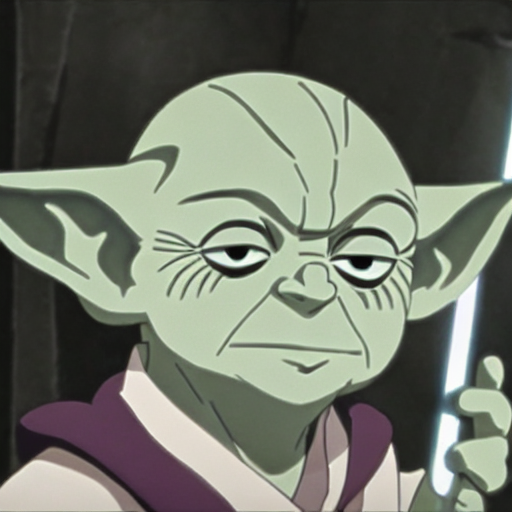

In [6]:
from diffusers import StableDiffusionPipeline
import torch

pipeline = StableDiffusionPipeline.from_pretrained(OBJECT_OUTPUT_DIR, torch_dtype=torch.float16, use_safetensors=True).to(t_device)

image = pipeline(prompt="yoda").images[0]
image